In [2]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

In [3]:
file = 'C:/Users/HP/Downloads/TimeTags_CW_Ful_2025-02-06_152655.ttbin' #QD_29 (CW)

In [4]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
Has data? -> True


In [5]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-02-06 15:26:56 +0100
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [6]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

{'configure version': 1,
 'current time': '2025-02-07 16:05:10 +0100',
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.17.4',
 'virtual inputs': []}


Correlation measurement is running.

Rate of counts channel 1 (counts/sec) : 13625.126323976352
Total counts channel 1 : 3294494
Rate of counts channel 2 (counts/sec) : 12573.712968855494
Total counts channel 2 : 3040267


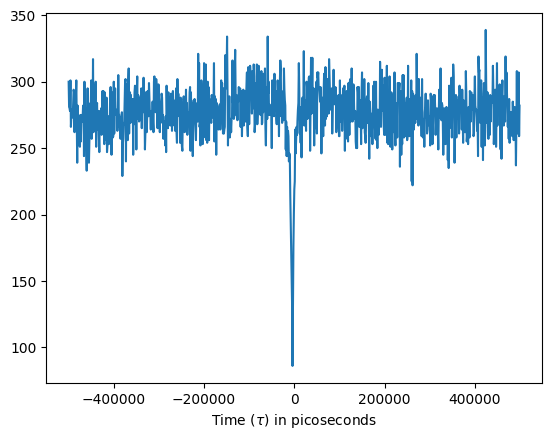

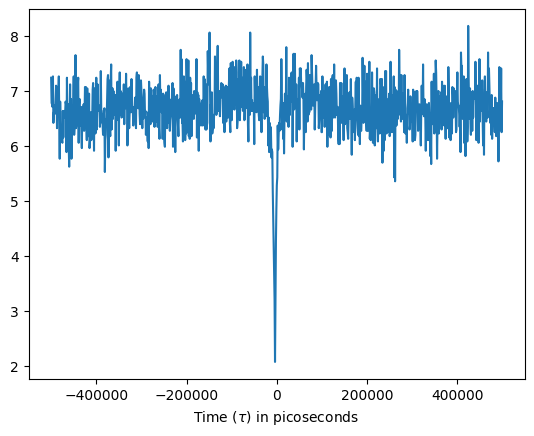

In [7]:
# measure photon antibunching
corr_ch1 = config['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config['registered channels'][1] # second photon channel for antibunching measurements
bwcorr = 1000 # 1 ns
nbins = 1000

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])
print("\nCorrelation measurement is running.\n")


virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
#virtual_tagger.replay(file, duration=8*10e11) # collect only 1 sec. of data (duration in picoseconds)
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr = corr.getIndex()
ycorr_norm = corr.getDataNormalized()
ycorr = corr.getData()

rate_ch1 = cr.getData()[0]
rate_ch2 = cr.getData()[1]
counts_ch1 = cr.getCountsTotal()[0]
counts_ch2 = cr.getCountsTotal()[1]

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Total counts channel {corr_ch1} : {cr.getCountsTotal()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Total counts channel {corr_ch2} : {cr.getCountsTotal()[1]}")

plt.plot(xcorr, ycorr)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

plt.plot(xcorr, ycorr_norm)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

In [8]:
# Normalize counts 
capture_duration = np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]) * 1e12 # Capture duration in picoseconds
print("Capture duration (seconds): ", np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]))
counts_normalized = (ycorr  * capture_duration)/(bwcorr * counts_ch1 * counts_ch2) 

Capture duration (seconds):  241.795482967569


In [24]:
# Define the fitting function: a * (1 - b * exp(abs(tau - t0) / tau0)
def fitting_function(tau, t_0, tau_0, a, b):
    return a * (1 - b * np.exp(-np.abs(tau - t_0) / tau_0))

# Function to normalize counts and fit the data
def fit_params(tau, counts, expected_a):
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=[-5, 10, expected_a, 1])
    
    return popt, pcov

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, t_0, tau_0, a, b, width, height, font_size):
    # Crear la figura
    plt.figure(figsize=(width, height))
    
    # Graficar los datos normalizados
    plt.plot(tau, counts, linestyle='-', color='black', linewidth=0.7, label='Normalized Data')
    
    # Generar la curva ajustada
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function(tau_fine, t_0, tau_0, a, b)
    
    # Graficar la curva ajustada
    plt.plot(tau_fine, fitted_curve, 'g-')
    
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # Activar la cuadrícula
    plt.grid(True)
    
    # Mostrar el gráfico
    plt.show()


## Obtention of the normalized graph

In [25]:
popt, pcov = fit_params(xcorr/1000, ycorr, 100)
# Extract fitted parameters
t_0, tau_0, a, b = popt

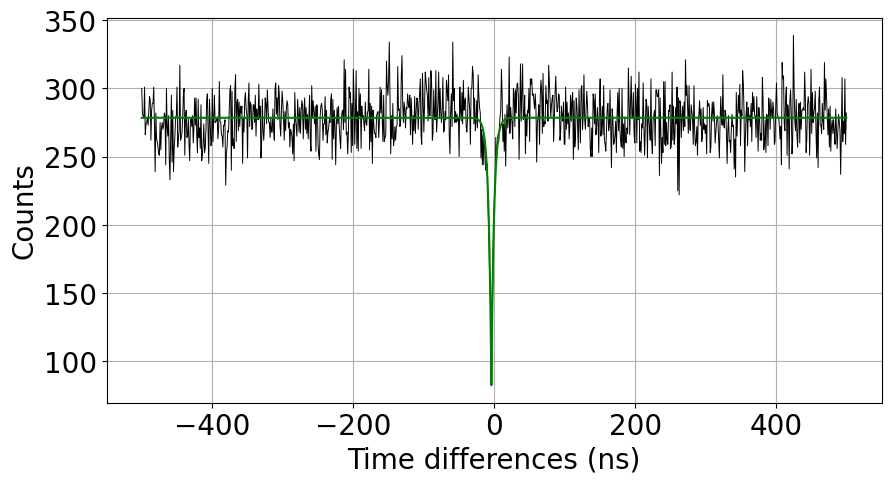

In [26]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr/1000, ycorr, t_0, tau_0, a, b, width=10, height=5, font_size=20)

## Obtention of the normalized graph

In [12]:
popt, pcov = fit_params(xcorr/1000, counts_normalized, 1)
# Extract fitted parameters
t_0, tau_0, a, b = popt

counts_normalized = counts_normalized/a

popt, pcov = fit_params(xcorr/1000, counts_normalized, 1)
# Extract fitted parameters
t_0, tau_0, a, b = popt

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))
error_t0, error_tau0, error_a, error_b = perr

# Print fitted parameters and their errors
print(f"Fitted parameters:\n t₀ = {t_0:.3f} ± {error_t0:.3f} ns \n a = {1:.3f} ± {error_a/a:.3f} \n b = {b/a:.3f} ± {error_b/a:.3f}")
print(f"Lifetime = {tau_0:.2f} ± {error_tau0:.2f} ns")

# Calculate g²(τ = t₀)
value_at_t_0 = fitting_function(t_0, t_0, tau_0, a, b)
error_value_at_t_0 = np.sqrt(error_a**2 + error_b**2)  # Estimate error propagation
print(f"g²(τ = t₀) = {value_at_t_0:.3f} ± {error_value_at_t_0:.3f}")

Fitted parameters:
 t₀ = -4.271 ± 0.173 ns 
 a = 1.000 ± 0.002 
 b = 0.709 ± 0.046
Lifetime = 3.80 ± 0.35 ns
g²(τ = t₀) = 0.291 ± 0.046


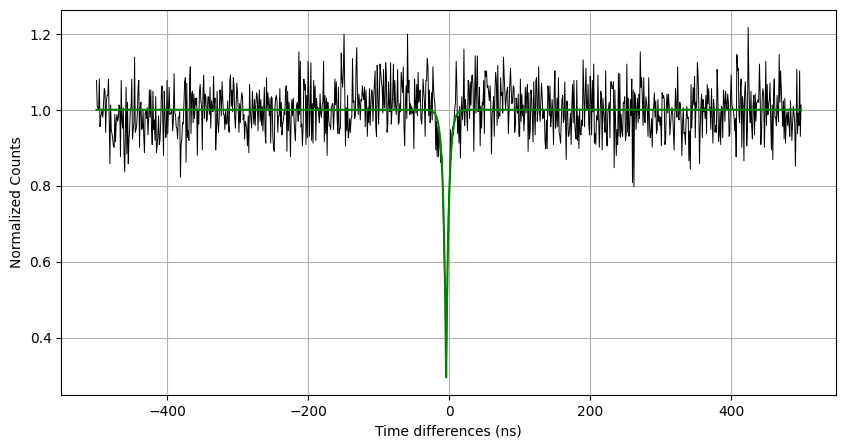

In [13]:
# Plot the normalized data and the fitted curve
counts_normalized = counts_normalized/a # Normalizamos las cuentas con el valor de a
plot_fit_noblinking(xcorr/1000, counts_normalized, t_0, tau_0, a, b, width=10, height=5)